In [1]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten,\
                         Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D,\
                          UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras import optimizers
import keras
import tensorflow as tf
from keras import callbacks
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from keras import applications
from keras.models import Model, Input,load_model


Using TensorFlow backend.


### try validation with another dataset, not the test set

In [2]:
tf.test.is_gpu_available

<function tensorflow.python.framework.test_util.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)>

In [3]:
#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())


In [4]:
# with tf.device('/gpu:0'):
#     a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
#     b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
#     c = tf.matmul(a, b)

# with tf.Session() as sess:
#     print (sess.run(c))

In [5]:
# from keras import backend as K
# K.tensorflow_backend._get_available_gpus()

In [6]:
datadir = 'D:\sapienza\ML\MWI-Dataset-1.1_2000'


In [7]:
testdir = 'D:\sapienza\ML\Weather_dataset'


In [39]:
batch_size = 20
input_shape = ()
train_datagen = ImageDataGenerator(
    rescale = 1. / 255,\
    zoom_range=0.4,\
    rotation_range=60,\
    width_shift_range=0.3,\
    height_shift_range=0.3,\
    horizontal_flip=True,\
    shear_range=0.3,
    zca_whitening=True,
    brightness_range=[0.5, 1.5],
    vertical_flip=False)

train_generator = train_datagen.flow_from_directory(
    directory=datadir,
    target_size=(350, 450),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=7
)

test_datagen = ImageDataGenerator(
    rescale = 1. / 255)

test_generator = test_datagen.flow_from_directory(
    directory=testdir,
    target_size=(350, 450),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
    seed=7
)

num_samples = train_generator.n
num_classes = train_generator.num_classes
input_shape = train_generator.image_shape

classnames = [k for k,v in train_generator.class_indices.items()]

C:\Users\Theo\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:336: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Found 2000 images belonging to 4 classes.
Found 3038 images belonging to 4 classes.


In [40]:
def load_backbone_net(input_shape):
    
    # define input tensor
    input0 = Input(shape=input_shape)

    # load a pretrained model on imagenet without the final dense layer
    feature_extractor = applications.vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=input0)
    
    
    feature_extractor = feature_extractor.output
    feature_extractor = Model(input=input0, output=feature_extractor)
    optimizer = 'SGD' #alternative 'SGD'

    feature_extractor.compile(loss=keras.losses.categorical_crossentropy, optimizer=optimizers.SGD(lr=1e-3,momentum=0.9,nesterov=True), metrics=['accuracy'])

    return feature_extractor


In [41]:
def transferNet(feature_extractor, num_classes, output_layer_name, trainable_layers):
    
    # get the original input layer tensor
    input_t = feature_extractor.get_layer(index=0).input

    # set the feture extractor layers as non-trainable
    for idx,layer in enumerate(feature_extractor.layers):
        if layer.name in trainable_layers:
            layer.trainable = True
        else:
            layer.trainable = False

    # get the output tensor from a layer of the feature extractor
    output_extractor = feature_extractor.get_layer(name = output_layer_name).output
    

    # flat the output of a Conv layer
    flatten = Flatten()(output_extractor) 
    flatten_norm = BatchNormalization()(flatten)
    dense = Dropout(0.4)(flatten_norm)
    

    
    

    # add a Dense layer
    dense = Dense(64, activation='relu')(dense)
    dense = BatchNormalization()(dense)
    dense = Dropout(0.2)(dense)

    # add the final output layer
    dense = BatchNormalization()(dense)
    dense = Dense(num_classes, activation='softmax')(dense)
    

    model = Model(input=input_t, output=dense, name="transferNet")
    
   # optimizer = 'adam' #alternative 'SGD'
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=optimizers.SGD(lr=1e-3,nesterov=True,momentum=0.9), metrics=['accuracy'])

    return model

In [42]:
# load the pre-trained model
feature_extractor = load_backbone_net(input_shape)
feature_extractor.summary()


# choose the layer from which you can get the features (block5_pool the end, glob_pooling to get the pooled version of the output)
name_output_extractor = "block5_pool"
trainable_layers = ["block5_conv3"]

# build the transfer model
transfer_model = transferNet(feature_extractor, num_classes, name_output_extractor, trainable_layers)
transfer_model.summary()

C:\Users\Theo\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("bl...)`
  # This is added back by InteractiveShellApp.init_path()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 350, 450, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 350, 450, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 350, 450, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 175, 225, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 175, 225, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 175, 225, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 87, 112, 128)      0         
__________

C:\Users\Theo\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="transferNet", inputs=Tensor("in..., outputs=Tensor("de...)`


In [12]:
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

# tf.global_variables_initializer()

# with tf.Session() as sess:
#      sess.run(tf.global_variables_initializer())

In [25]:
#keras.backend.get_session().run(tf.global_variables_initializer())

In [43]:
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", 
                               monitor = 'val_acc',
                               verbose=1, 
                               save_best_only=True)

In [44]:
# fit the transferNet on the training data
stopping = callbacks.EarlyStopping(monitor='val_acc', patience=4)

steps_per_epoch = train_generator.n//train_generator.batch_size
val_steps = test_generator.n//test_generator.batch_size+1

try:
    history_transfer = transfer_model.fit_generator(train_generator, epochs=20, verbose=1, callbacks=[stopping,checkpointer],\
                    steps_per_epoch=steps_per_epoch,
                    validation_data=test_generator,
                    validation_steps=val_steps,
                    use_multiprocessing=True,
                    workers=0)
except KeyboardInterrupt:
    pass

Epoch 1/20


C:\Users\Theo\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Theo\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 33/100 [========>.....................] - ETA: 2:06 - loss: 1.3174 - acc: 0.5258

C:\Users\Theo\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\Theo\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 131072 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\Theo\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1048576 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


 40/100 [===========>..................] - ETA: 1:53 - loss: 1.2220 - acc: 0.5538

C:\Users\Theo\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 4. Skipping tag 41486
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\Theo\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag))


 71/100 [====================>.........] - ETA: 54s - loss: 1.1071 - acc: 0.5915

C:\Users\Theo\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:780: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


 89/100 [=========================>....] - ETA: 20s - loss: 1.0444 - acc: 0.6140

C:\Users\Theo\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41486
  " Skipping tag %s" % (size, len(data), tag))


100/100 [==============================] - 344s 3s/step - loss: 1.0296 - acc: 0.6190 - val_loss: 1.8338 - val_acc: 0.4259

Epoch 00001: val_acc improved from -inf to 0.42594, saving model to best_weights.hdf5
Epoch 2/20
100/100 [==============================] - 341s 3s/step - loss: 0.7448 - acc: 0.7155 - val_loss: 1.5489 - val_acc: 0.4585

Epoch 00002: val_acc improved from 0.42594 to 0.45853, saving model to best_weights.hdf5
Epoch 3/20
100/100 [==============================] - 348s 3s/step - loss: 0.6882 - acc: 0.7355 - val_loss: 1.5803 - val_acc: 0.4941

Epoch 00003: val_acc improved from 0.45853 to 0.49408, saving model to best_weights.hdf5
Epoch 4/20
100/100 [==============================] - 351s 4s/step - loss: 0.6171 - acc: 0.7560 - val_loss: 1.3762 - val_acc: 0.5046

Epoch 00004: val_acc improved from 0.49408 to 0.50461, saving model to best_weights.hdf5
Epoch 5/20
100/100 [==============================] - 356s 4s/step - loss: 0.5947 - acc: 0.7675 - val_loss: 1.7067 - val_a

In [45]:
loss, acc = transfer_model.evaluate_generator(test_generator,verbose=1,steps=val_steps, use_multiprocessing=True,workers=0)
print('Test loss: %f' %loss)
print('Test accuracy: %f' %acc)

152/152 [==============================] - 157s 1s/step
Test loss: 1.445015
Test accuracy: 0.534233


In [34]:
#transfer_model.load_weights('best_weights.hdf5')


In [48]:
transfer_model.save('MWI-2000-4classes-VGG-17epochs')

In [53]:
transfer_model = load_model('MWI-2000-4classes-VGG-17epochs')

In [54]:
preds = transfer_model.predict_generator(test_generator,verbose=1,steps=val_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = test_generator.classes  # shuffle=False in test_generator

print(classification_report(Ytest, Ypred, labels=None, target_names=classnames, digits=3))


152/152 [==============================] - 130s 854ms/step
              precision    recall  f1-score   support

        HAZE      0.000     0.000     0.000         0
       RAINY      0.367     0.509     0.426       521
       SNOWY      0.674     0.706     0.690      1421
       SUNNY      0.809     0.324     0.463      1096

   micro avg      0.534     0.534     0.534      3038
   macro avg      0.462     0.385     0.395      3038
weighted avg      0.670     0.534     0.563      3038



C:\Users\Theo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [55]:
# predictions from transferNet
preds = transfer_model.predict_generator(test_generator,verbose=1,steps=val_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = test_generator.classes  # shuffle=False in test_generator

cm = confusion_matrix(Ytest, Ypred)

conf = [] # data structure for confusions: list of (i,j,cm[i][j])
for i in range(0,cm.shape[0]):
    for j in range(0,cm.shape[1]):
        if (i!=j and cm[i][j]>0):
            conf.append([i,j,cm[i][j]])

col=2
conf = np.array(conf)
conf = conf[np.argsort(-conf[:,col])]  # decreasing order by 3-rd column (i.e., cm[i][j])

print('%-16s     %-16s  \t%s \t%s ' %('True','Predicted','errors','err %'))
print('------------------------------------------------------------------')
for k in conf:
    print('%-16s ->  %-16s  \t%d \t%.2f %% ' %(classnames[k[0]],classnames[k[1]],k[2],k[2]*100.0/test_generator.n))

152/152 [==============================] - 130s 856ms/step
True                 Predicted         	errors 	err % 
------------------------------------------------------------------
SUNNY            ->  RAINY             	321 	10.57 % 
SUNNY            ->  SNOWY             	313 	10.30 % 
SUNNY            ->  HAZE              	154 	5.07 % 
RAINY            ->  HAZE              	148 	4.87 % 
SNOWY            ->  RAINY             	146 	4.81 % 
SNOWY            ->  SUNNY             	129 	4.25 % 
RAINY            ->  SNOWY             	116 	3.82 % 
SNOWY            ->  HAZE              	87 	2.86 % 
RAINY            ->  SUNNY             	2 	0.07 % 


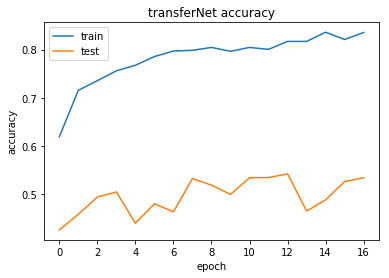

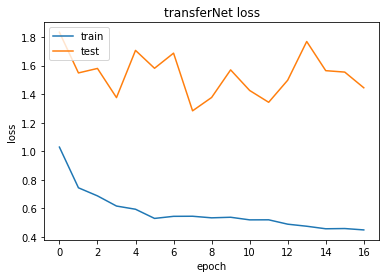

In [56]:
def plot_history(history,name):

    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(name + ' accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(name + ' loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


name="transferNet"
plot_history(history_transfer, name)


In [98]:
import os

In [105]:
pred_list=[]
img_dir='D:/sapienza\ML/WeatherBlindTestSet/'
for i,img in enumerate(os.listdir(img_dir)):
    img = image.load_img(os.path.join(img_dir,img), target_size=(350,450))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    result=model.predict(img_tensor)
    pred_list.append(np.argmax(result))
    


In [127]:
inv_map = dict(zip(train_generator.class_indices.values(), train_generator.class_indices.keys()))

In [138]:
import csv


In [147]:
#new_preds=[]
#for item in pred_list:
    #new_preds.append(inv_map[item])
    
with open('predictions.csv', mode='w') as file:
    writer=csv.writer(file,delimiter='\t',lineterminator='\n')
    for item in pred_list:
        writer.writerow(inv_map[item])
    
        
        

In [142]:
pwd

'C:\\Users\\Theo'